In [90]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance
import pytesseract
import re
from datetime import datetime
from collections import Counter
import warnings
import json
import pickle
import tempfile
import os
import re
plt.style.use('seaborn-v0_8-darkgrid')

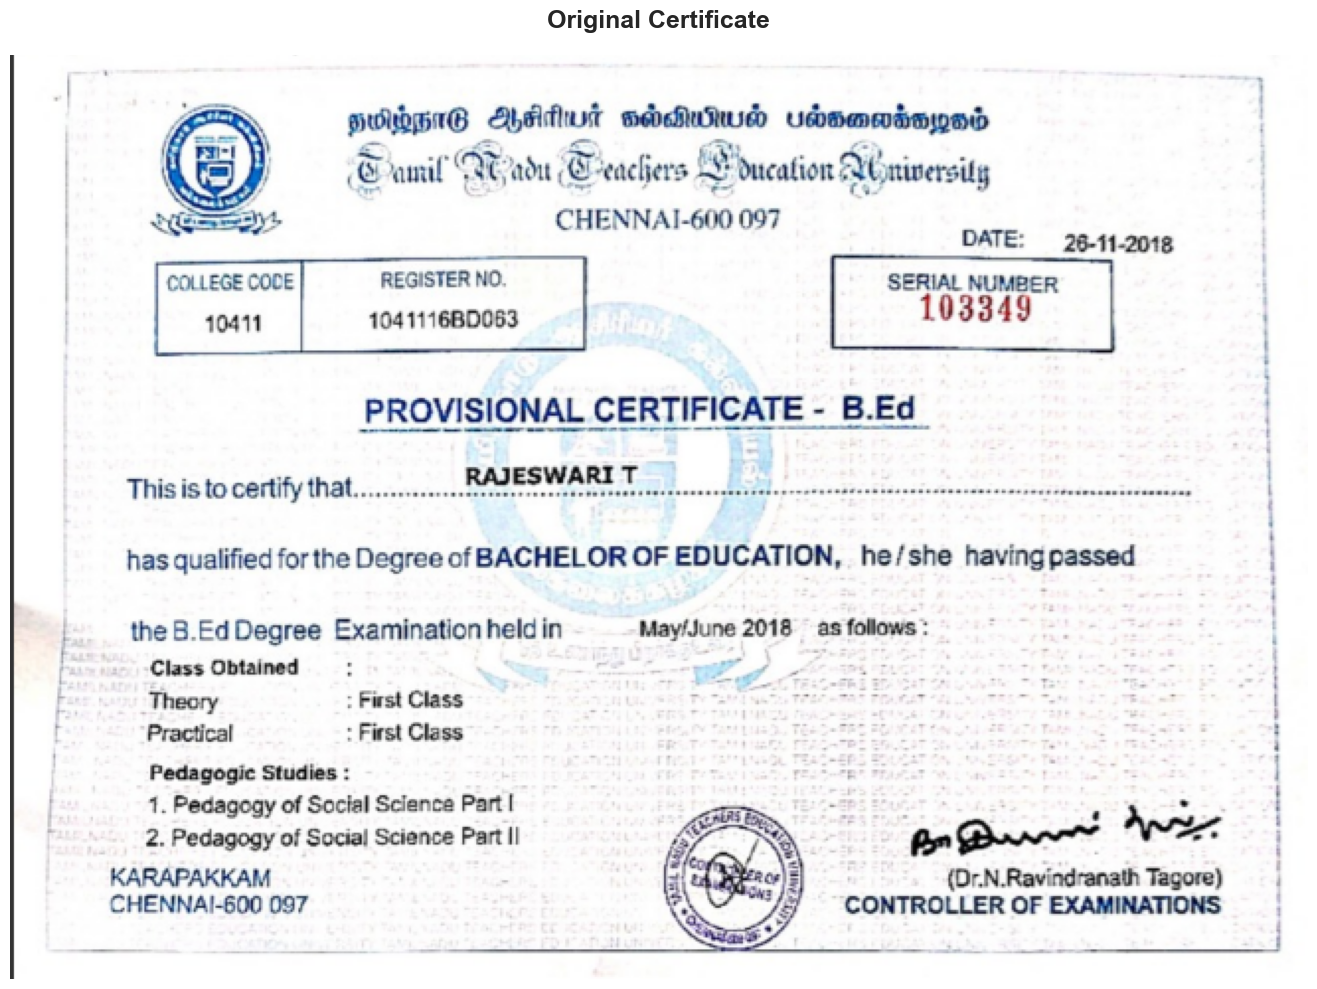

  Image size: 657 x 468 pixels
  Color channels: 3


In [92]:
image_path = "C:/Users/infin/Desktop/sample.png"

try:
    cert_image = cv2.imread(image_path)
    
    if cert_image is None:
        raise FileNotFoundError(f"Could not load image at: {image_path}")
    
    # Convert BGR to RGB
    cert_rgb = cv2.cvtColor(cert_image, cv2.COLOR_BGR2RGB)
    

    plt.figure(figsize=(14, 10))
    plt.imshow(cert_rgb)
    plt.title("Original Certificate", fontsize=18, fontweight='bold', pad=20)
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    # Print info
    height, width, channels = cert_image.shape
    print(f"  Image size: {width} x {height} pixels")
    print(f"  Color channels: {channels}")
    
except Exception as e:
    print(f"Error: {e}")

    raise

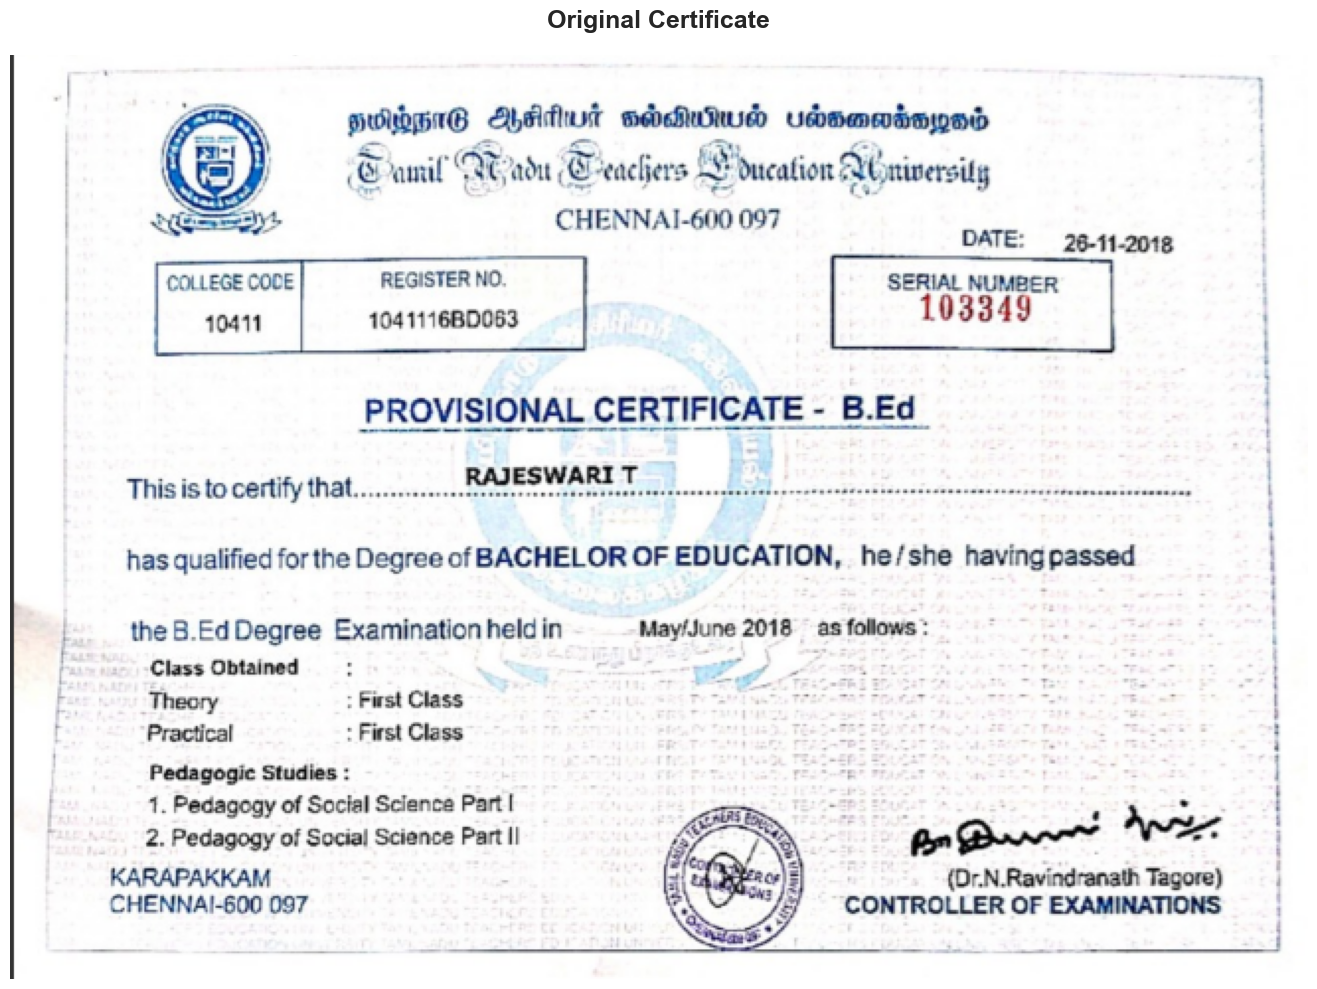


Certificate loaded successfully!
  Image size: 657 x 468 pixels
  File size: 0.88 MB
  Color channels: 3


In [ ]:
image_path = "C:/Users/infin/Desktop/sample.png"

try:
    cert_image = cv2.imread(image_path)
    if cert_image is None:
        raise FileNotFoundError("Could not load the image")
    
    #BGR to RGB
    cert_rgb = cv2.cvtColor(cert_image, cv2.COLOR_BGR2RGB)
    

    plt.figure(figsize=(14, 10))
    plt.imshow(cert_rgb)
    plt.title("Original Certificate", fontsize=18, fontweight='bold', pad=20)
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
   
    height, width, channels = cert_image.shape
    print(f"\nCertificate loaded successfully!")
    print(f"  Image size: {width} x {height} pixels")
    print(f"  Color channels: {channels}")
    
except Exception as e:
    print(f" Error: {e}")

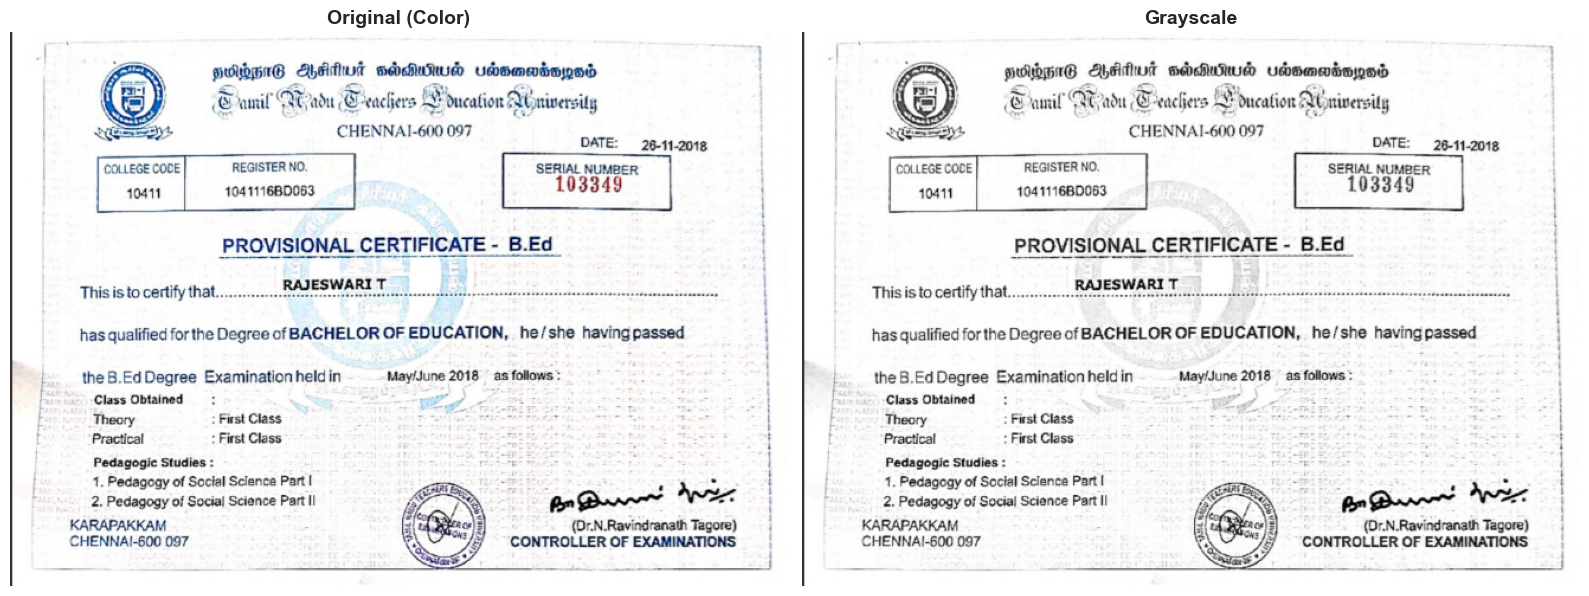

 Converted to grayscale
  Original shape: (468, 657, 3)
  Grayscale shape: (468, 657)


In [71]:
# Convert to grayscale
gray_image = cv2.cvtColor(cert_image, cv2.COLOR_BGR2GRAY)

# Let's compare the original and grayscale versions
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

axes[0].imshow(cert_rgb)
axes[0].set_title("Original (Color)", fontsize=14, fontweight='bold')
axes[0].axis('off')

axes[1].imshow(gray_image, cmap='gray')
axes[1].set_title("Grayscale", fontsize=14, fontweight='bold')
axes[1].axis('off')

plt.tight_layout()
plt.show()

print(" Converted to grayscale")
print(f"  Original shape: {cert_rgb.shape}")
print(f"  Grayscale shape: {gray_image.shape}")




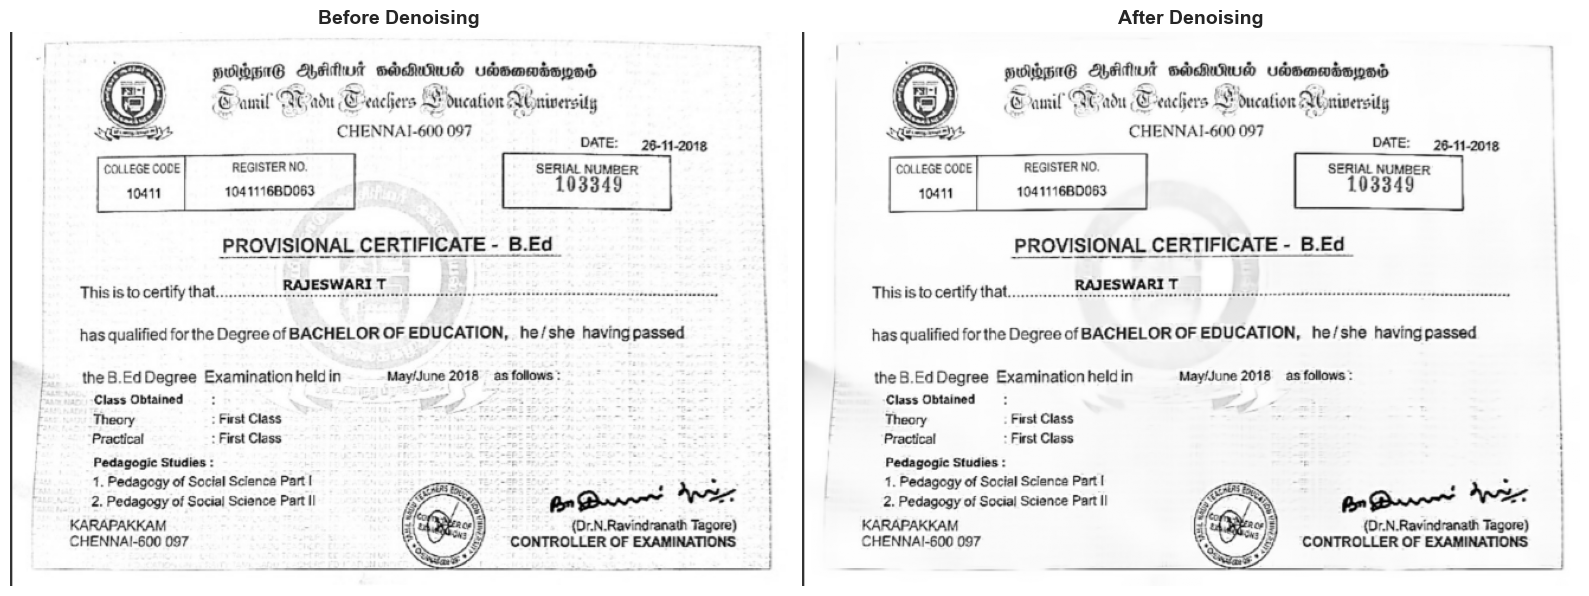

Noise removed successfully
  The image is now cleaner and text should be easier to read


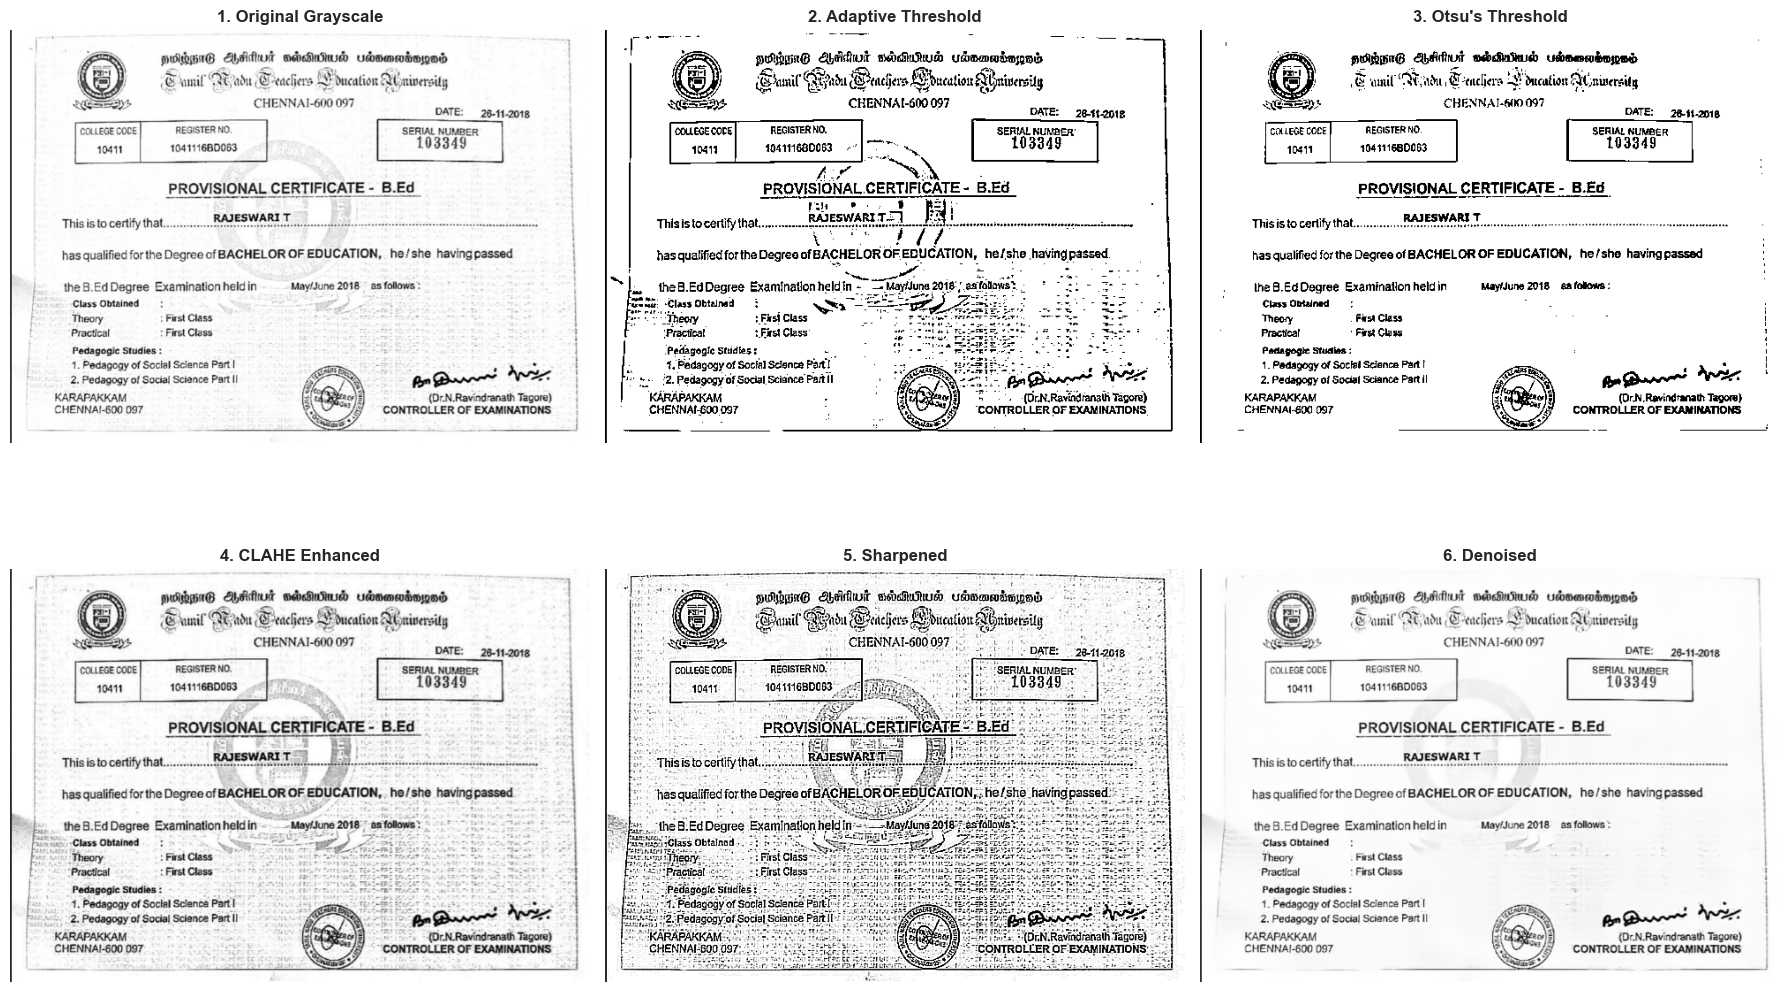

Created 5 different enhanced versions
  We'll use all of them to maximize text extraction accuracy


In [ ]:

# denoising
denoised = cv2.fastNlMeansDenoising(gray_image, None, h=10, templateWindowSize=7, searchWindowSize=21)

# Compare before and after
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

axes[0].imshow(gray_image, cmap='gray')
axes[0].set_title("Before Denoising", fontsize=14, fontweight='bold')
axes[0].axis('off')

axes[1].imshow(denoised, cmap='gray')
axes[1].set_title("After Denoising", fontsize=14, fontweight='bold')
axes[1].axis('off')

plt.tight_layout()
plt.show()

print("Noise removed successfully")
print("  The image is now cleaner and text should be easier to read")

# Method 1: Adaptive Thresholding
adaptive_thresh = cv2.adaptiveThreshold(
    denoised, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
    cv2.THRESH_BINARY, 11, 2
)

# Method 2: Otsu's Thresholding
_, otsu_thresh = cv2.threshold(
    denoised, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU
)

# Method 3: CLAHE (Contrast Limited Adaptive Histogram Equalization)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
clahe_enhanced = clahe.apply(gray_image)

# Method 4: Sharpening
kernel_sharpen = np.array([[-1, -1, -1], 
                           [-1,  9, -1], 
                           [-1, -1, -1]])
sharpened = cv2.filter2D(clahe_enhanced, -1, kernel_sharpen)

# Display all methods
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

axes[0, 0].imshow(gray_image, cmap='gray')
axes[0, 0].set_title("1. Original Grayscale", fontsize=12, fontweight='bold')
axes[0, 0].axis('off')

axes[0, 1].imshow(adaptive_thresh, cmap='gray')
axes[0, 1].set_title("2. Adaptive Threshold", fontsize=12, fontweight='bold')
axes[0, 1].axis('off')

axes[0, 2].imshow(otsu_thresh, cmap='gray')
axes[0, 2].set_title("3. Otsu's Threshold", fontsize=12, fontweight='bold')
axes[0, 2].axis('off')

axes[1, 0].imshow(clahe_enhanced, cmap='gray')
axes[1, 0].set_title("4. CLAHE Enhanced", fontsize=12, fontweight='bold')
axes[1, 0].axis('off')

axes[1, 1].imshow(sharpened, cmap='gray')
axes[1, 1].set_title("5. Sharpened", fontsize=12, fontweight='bold')
axes[1, 1].axis('off')

axes[1, 2].imshow(denoised, cmap='gray')
axes[1, 2].set_title("6. Denoised", fontsize=12, fontweight='bold')
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

print("Created 5 different enhanced versions")
print("  We'll use all of them to maximize text extraction accuracy")

preprocessed_images = {
    'adaptive': adaptive_thresh,
    'otsu': otsu_thresh,
    'clahe': clahe_enhanced,
    'sharpened': sharpened,
    'denoised': denoised
}

In [96]:
def perform_ocr_on_image(image, method_name):
    """Extract text from a single image"""
    try:
        # Configure Tesseract
        config = '--oem 3 --psm 6'  # LSTM engine, assume uniform text block
        
        # Extract text
        text = pytesseract.image_to_string(image, lang='eng', config=config)
        
        # Get confidence scores
        data = pytesseract.image_to_data(image, lang='eng', config=config, 
                                         output_type=pytesseract.Output.DICT)
        confidences = [int(conf) for conf in data['conf'] if int(conf) > 0]
        avg_confidence = np.mean(confidences) if confidences else 0
        
        return text, avg_confidence
    except Exception as e:
        print(f"    Error with {method_name}: {e}")
        return "", 0

# Run OCR on all preprocessed images
print("Running OCR on all preprocessed versions...")

ocr_results = {}
for method_name, image in preprocessed_images.items():
    print(f"\nProcessing: {method_name.upper()}")
    text, confidence = perform_ocr_on_image(image, method_name)
    ocr_results[method_name] = {
        'text': text,
        'confidence': confidence
    }
    print(f"   Confidence: {confidence:.1f}%")
    print(f"   Extracted {len(text)} characters")

print("OCR Complete!")

# Find the best result
best_method = max(ocr_results.items(), key=lambda x: x[1]['confidence'])
print(f"\n Best method: {best_method[0].upper()} ({best_method[1]['confidence']:.1f}% confidence)")


Running OCR on all preprocessed versions...

Processing: ADAPTIVE
   Confidence: 44.6%
   Extracted 740 characters

Processing: OTSU
   Confidence: 55.9%
   Extracted 634 characters

Processing: CLAHE
   Confidence: 57.2%
   Extracted 647 characters

Processing: SHARPENED
   Confidence: 34.1%
   Extracted 905 characters

Processing: DENOISED
   Confidence: 68.3%
   Extracted 631 characters
OCR Complete!

 Best method: DENOISED (68.3% confidence)


In [ ]:
best_text = best_method[1]['text']

print(" Extracted Text from Certificate:")
print("=" * 80)
print(best_text)
print("=" * 80)

lines = [line.strip() for line in best_text.split('\n') if line.strip()]
print(f"\n Found {len(lines)} lines of text")

print("\nFirst 10 lines:")
for i, line in enumerate(lines[:10], 1):
    print(f"  {i:2d}. {line}")

 Extracted Text from Certificate:
GE POBG ALitwt odeiuud vdHmviqyod
q Se. > fia! oa
(&) FSi Nadu Teachers Woucation Mniversity
3S (CHENNAI-600 097
we DATE: 26-11-2018
THLLEGECOCE] _ REGISTERNO. SERIAL NUMBER
10411 104111660083 103349
PROVISIONAL CERTIFICATE - B.Ed_
has qualified for the Degree of BACHELOR OF EDUCATION, he/she havingpassed |
the B.Ed Degree Examination held in May/June 2018 as follows :
Class Obtained:
Theory First Class |
Practical First Class t
Pedagogie Studies : |
1. Pecagogy of Socal Science Part ee
2, Pedagogy of Social Sciance Part eo Prune wen
KARAPAKKAM HEC: ce (O:N.Ravind-anath Tagore)
CHENNA-600 057 AP) CONTROLLER OF EXAMINATIONS


 Found 18 lines of text

First 10 lines:
   1. GE POBG ALitwt odeiuud vdHmviqyod
   2. q Se. > fia! oa
   3. (&) FSi Nadu Teachers Woucation Mniversity
   4. 3S (CHENNAI-600 097
   5. we DATE: 26-11-2018
   6. THLLEGECOCE] _ REGISTERNO. SERIAL NUMBER
   7. 10411 104111660083 103349
   8. PROVISIONAL CERTIFICATE - B.Ed_
   9. has qu

In [99]:

def calculate_ela(image_path):
    """
    Calculate Error Level Analysis
    Lower scores = more authentic
    Higher scores = potentially tampered
    """
    try:
        # Open original image
        img = Image.open(image_path)
        
        # Save with high quality
        temp_path = tempfile.mktemp(suffix='.jpg')
        img.save(temp_path, 'JPEG', quality=95)
        
        # Load both versions
        original = cv2.imread(image_path)
        resaved = cv2.imread(temp_path)
        
        import os
        try:
            os.unlink(temp_path)
        except:
            pass
        
        if original is None or resaved is None:
            return 30, "unknown"
        
        # Calculate difference
        diff = cv2.absdiff(original, resaved)
        diff_gray = cv2.cvtColor(diff, cv2.COLOR_BGR2GRAY)
        
        # Calculate error metric
        std_error = np.std(diff_gray)
        mean_error = np.mean(diff_gray)
        
        # Score based on error levels
        if std_error < 5 and mean_error < 10:
            score = 10
            verdict = "authentic"
        elif std_error < 15 and mean_error < 20:
            score = 25
            verdict = "likely_authentic"
        elif std_error < 30:
            score = 50
            verdict = "suspicious"
        else:
            score = 80
            verdict = "likely_forgery"
        
        return score, verdict, diff
        
    except Exception as e:
        print(f"ELA error: {e}")
        return 30, "unknown", None

# Perform ELA
tampering_score, verdict, ela_diff = calculate_ela(image_path)

print(f"  Score: {tampering_score}/100")
print(f"  Verdict: {verdict.upper().replace('_', ' ')}")
print(f"  Authenticity: {100 - tampering_score}%")

# Visualize ELA if available
if ela_diff is not None:
    fig, axes = plt.subplots(1, 2, figsize=(16, 7))
    
    axes[0].imshow(cert_rgb)
    axes[0].set_title("Original Certificate", fontsize=14, fontweight='bold')
    axes[0].axis('off')
    
    ela_colored = cv2.applyColorMap(ela_diff, cv2.COLORMAP_JET)
    ela_colored = cv2.cvtColor(ela_colored, cv2.COLOR_BGR2RGB)
    axes[1].imshow(ela_colored)
    axes[1].set_title("ELA Heatmap (brighter = more suspicious)", fontsize=14, fontweight='bold')
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print("\n Interpretation:")
    if tampering_score < 20:
        print("  Certificate appears authentic")
        print("  No significant tampering detected")
    elif tampering_score < 60:
        print("   Some irregularities detected")
        print("   Manual verification recommended")
    else:
        print("  High likelihood of tampering")
        print("  Certificate may be forged")

ELA error: cannot write mode RGBA as JPEG
  Score: 30/100
  Verdict: UNKNOWN
  Authenticity: 70%


In [104]:
def preprocess_image(image_path):
    """Preprocess image for better OCR"""
    img = cv2.imread(image_path)
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    height, width = gray.shape
    if height < 1000:
        scale = 2000 / height
        new_width = int(width * scale)
        new_height = int(height * scale)
        gray = cv2.resize(gray, (new_width, new_height), interpolation=cv2.INTER_CUBIC)
    
    # Increase contrast
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    enhanced = clahe.apply(gray)
    # Denoise
    denoised = cv2.fastNlMeansDenoising(enhanced, h=10)
    # Threshold
    _, thresh = cv2.threshold(denoised, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    return thresh

def extract_text_with_better_ocr(image_path):
    """Extract text with improved OCR"""
    print("Preprocessing image...")
    preprocessed = preprocess_image(image_path)
    
    print("Running OCR...")
    # Try multiple PSM modes for better results
    custom_config = r'--oem 3 --psm 6'
    text = pytesseract.image_to_string(preprocessed, config=custom_config)
    
    # If poor results, try PSM 3 (automatic)
    if len(text.strip()) < 100:
        custom_config = r'--oem 3 --psm 3'
        text = pytesseract.image_to_string(preprocessed, config=custom_config)
    
    return text

def extract_name(lines, full_text):
    """Extract student name from certificate text"""
    candidates = []
    
    exclude_keywords = [
        'CERTIFICATE', 'UNIVERSITY', 'DEGREE', 'EDUCATION', 'COLLEGE',
        'BACHELOR', 'MASTER', 'DIPLOMA', 'EXAMINATION', 'COURSE',
        'REGISTER', 'SERIAL', 'CODE', 'PROVISIONAL', 'QUALIFIED',
        'OBTAINED', 'THEORY', 'PRACTICAL', 'PEDAGOG', 'SCIENCE',
        'CONTROLLER', 'CHENNAI', 'DATE', 'CLASS', 'FIRST', 'TEACHERS',
        'TAMIL', 'NADU', 'APRIL', 'MAY', 'JUNE', 'JULY', 'AUGUST'
    ]
    
    def is_valid_name(text):
        if not text or len(text.strip()) < 2 or len(text.strip()) > 60:
            return False
        
        text_upper = text.upper().strip()
        
        for keyword in exclude_keywords:
            if keyword in text_upper:
                return False
        
        alpha_count = sum(c.isalpha() or c.isspace() for c in text)
        if len(text) > 0 and alpha_count / len(text) < 0.60:
            return False
        
        words = [w for w in text.split() if len(w) > 0]
        if len(words) == 0 or len(words) > 5:
            return False
        
        if sum(c.isdigit() for c in text) > 4:
            return False
        
        return True
    
    def clean_name(text):
        text = re.sub(r'[^A-Za-z\s\.]', ' ', text)
        text = ' '.join(text.split())
        text = text.strip('. ')
        
        words = text.split()
        clean_words = []
        for word in words:
            # Stop at very short words (likely artifacts) unless it's a single capital letter (initial)
            if len(word) == 1 and word.isupper():
                clean_words.append(word)
                break  # Stop after initial
            elif len(word) >= 3:
                clean_words.append(word)
            elif len(word) == 2 and word[0].isupper() and word[1].isupper():
                clean_words.append(word)
        
        return ' '.join(clean_words)
    
    def calculate_score(name):
        score = 0
        words = name.split()
        
        if len(words) == 2:
            score += 15
        elif len(words) == 3:
            score += 12
        
        if any(len(w) == 1 for w in words):
            score += 10
        
        name_upper = name.upper()
        if any(end in name_upper for end in ['SWARI', 'KUMAR', 'SINGH', 'WARI', 'PRIYA', 'RAJA', 'DEVI', 'LAKSHMI']):
            score += 10
        
        return score
    
    # STRATEGY 1: Pattern matching - more precise
    cert_patterns = [
        r'certify\s+that\s+([A-Z][a-z]+(?:\s+[A-Z])?)\s',
        r'This is to certify that\s+([A-Z][a-z]+(?:\s+[A-Z])?)\s',
    ]
    
    for pattern in cert_patterns:
        matches = re.finditer(pattern, full_text, re.IGNORECASE)
        for match in matches:
            name = clean_name(match.group(1))
            if is_valid_name(name):
                candidates.append(('cert_pattern', name, 98 + calculate_score(name)))
    
    # STRATEGY 2: Line before "has qualified"
    for i, line in enumerate(lines):
        if 'has qualified' in line.lower() or 'qualified for' in line.lower():
            for offset in range(1, 4):
                check_idx = i - offset
                if 0 <= check_idx < len(lines):
                    potential = clean_name(lines[check_idx].strip())
                    if potential and is_valid_name(potential):
                        conf = 95 - (offset * 2) + calculate_score(potential)
                        candidates.append(('before_qualified', potential, conf))
    
    # STRATEGY 3: After "certify" keyword
    for i, line in enumerate(lines):
        if 'certify' in line.lower():
            for offset in range(0, 5):
                if i + offset < len(lines):
                    potential = clean_name(lines[i + offset].strip())
                    if potential and is_valid_name(potential):
                        conf = 92 - (offset * 2) + calculate_score(potential)
                        candidates.append(('after_certify', potential, conf))
    
    # STRATEGY 4: Two-word with initial pattern (e.g., "RAJESWARI T")
    for i, line in enumerate(lines):
        if i < 2 or i > len(lines) - 5:
            continue
        
        # Look for pattern: Word + Single Letter
        match = re.search(r'\b([A-Z][a-z]{3,})\s+([A-Z])\b', line)
        if match:
            name = f"{match.group(1)} {match.group(2)}"
            if is_valid_name(name):
                conf = 96 + calculate_score(name)
                candidates.append(('name_initial_pattern', name, conf))
        
        # Also check cleaned line
        line_clean = clean_name(line.strip())
        if not line_clean:
            continue
        
        words = line_clean.split()
        
        # Pattern: Two words, second is single letter
        if len(words) == 2 and len(words[1]) == 1 and words[1].isupper():
            if is_valid_name(line_clean):
                conf = 95 + calculate_score(line_clean)
                candidates.append(('two_word_initial', line_clean, conf))
        
        # Pattern: Title Case 2-3 words
        elif 2 <= len(words) <= 3 and all(w[0].isupper() for w in words if len(w) > 0):
            if is_valid_name(line_clean):
                conf = 88 + calculate_score(line_clean)
                candidates.append(('title_case', line_clean, conf))
        
        # Pattern: ALL CAPS short line
        elif line.strip().isupper() and len(words) <= 3:
            if is_valid_name(line_clean):
                conf = 85 + calculate_score(line_clean)
                candidates.append(('all_caps', line_clean, conf))
    
    #  S/O, D/O pattern
    for i, line in enumerate(lines):
        if re.search(r'S/O|D/O|W/O', line, re.IGNORECASE):
            if i > 0:
                potential = clean_name(lines[i - 1].strip())
                if potential and is_valid_name(potential):
                    conf = 96 + calculate_score(potential)
                    candidates.append(('before_relation', potential, conf))
    
    if not candidates:
        return None, 0
    
    unique_candidates = {}
    for source, name, conf in candidates:
        name_norm = ' '.join(name.upper().split())
        
        if name_norm not in unique_candidates:
            unique_candidates[name_norm] = {'name': name, 'conf': conf, 'count': 1}
        else:
            unique_candidates[name_norm]['count'] += 1
            if conf > unique_candidates[name_norm]['conf']:
                unique_candidates[name_norm]['name'] = name
                unique_candidates[name_norm]['conf'] = conf

    for key in unique_candidates:
        if unique_candidates[key]['count'] > 1:
            boost = min(15, unique_candidates[key]['count'] * 5)
            unique_candidates[key]['conf'] = min(99, unique_candidates[key]['conf'] + boost)
    
    sorted_candidates = sorted(
        unique_candidates.values(),
        key=lambda x: x['conf'],
        reverse=True
    )
    
    if sorted_candidates:
        best = sorted_candidates[0]
        return best['name'], best['conf']
    
    return None, 0


image_path = "C:/Users/infin/Desktop/sample.png"

best_text = extract_text_with_better_ocr(image_path)
lines = best_text.split('\n')

for i, line in enumerate(lines[:20]):
    print(f"{i:2d}: {line.strip()}")
name, name_confidence = extract_name(lines, best_text)

if name:
    print(f"Student Name: {name}")
else:
    print("No name detected")
    print("Manual review required")

Preprocessing image...
Running OCR...
 0: podenG Adidiuxt adatud vdSavdaged
 1: 
 2: | \ ( 4 FSi AE ade Teachers Poucalion XGniversity
 3: 
 4: | CHENNAI-600 097
 5: 
 6: ! DATE: 26-11-2018 |
 7: | COLLEGE COCE REGISTER NO. SERIAL NUMBER }
 8: ! 10411 104111680083 - 103349 }
 9: an
10: PROVISIONAL CERTIFICATE - B.Ed
11: Tissot Rt a RABESWARET |
12: has qualified for the Degree of BACHELOR OF EDUCATION, he/she having passed |
13: . the B.Ed Degree Examination held in - _— ieyhdune 2018 as follows ° Fe ee |
14: 2, Pedagogy of Social Science Part II a B= - Ow Wee
15: KARAPAKKAM RN = cNRavindranath Tagore)
16: CHENNAI-600 097 oy, “CONTROLLER OF EXAMNUATIONS
17: 
Student Name: Tissot RABESWARET


In [106]:
def preprocess_image(image_path):
    """Preprocess image for better OCR"""
    # Read image
    img = cv2.imread(image_path)
    
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    height, width = gray.shape
    if height < 1000:
        scale = 2000 / height
        new_width = int(width * scale)
        new_height = int(height * scale)
        gray = cv2.resize(gray, (new_width, new_height), interpolation=cv2.INTER_CUBIC)
    
    # Increase contrast
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    enhanced = clahe.apply(gray)
    
    # Denoise
    denoised = cv2.fastNlMeansDenoising(enhanced, h=10)
    
    # Threshold
    _, thresh = cv2.threshold(denoised, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    return thresh

def extract_text_with_better_ocr(image_path):
    """Extract text with improved OCR"""
    print("Preprocessing image...")
    preprocessed = preprocess_image(image_path)
    
    print("Running OCR...")
    # Try multiple PSM modes for better results
    custom_config = r'--oem 3 --psm 6'
    text = pytesseract.image_to_string(preprocessed, config=custom_config)
    
    # If poor results, try PSM 3 (automatic)
    if len(text.strip()) < 100:
        custom_config = r'--oem 3 --psm 3'
        text = pytesseract.image_to_string(preprocessed, config=custom_config)
    
    return text

def extract_name(lines, full_text):
    """Extract student name from certificate text"""
    candidates = []
    
    exclude_keywords = [
        'CERTIFICATE', 'UNIVERSITY', 'DEGREE', 'EDUCATION', 'COLLEGE',
        'BACHELOR', 'MASTER', 'DIPLOMA', 'EXAMINATION', 'COURSE',
        'REGISTER', 'SERIAL', 'CODE', 'PROVISIONAL', 'QUALIFIED',
        'OBTAINED', 'THEORY', 'PRACTICAL', 'PEDAGOG', 'SCIENCE',
        'CONTROLLER', 'CHENNAI', 'DATE', 'CLASS', 'FIRST', 'TEACHERS',
        'TAMIL', 'NADU', 'APRIL', 'MAY', 'JUNE', 'JULY', 'AUGUST'
    ]
    
    def is_valid_name(text):
        if not text or len(text.strip()) < 2 or len(text.strip()) > 60:
            return False
        
        text_upper = text.upper().strip()
        
        for keyword in exclude_keywords:
            if keyword in text_upper:
                return False
        
        alpha_count = sum(c.isalpha() or c.isspace() for c in text)
        if len(text) > 0 and alpha_count / len(text) < 0.60:
            return False
        
        words = [w for w in text.split() if len(w) > 0]
        if len(words) == 0 or len(words) > 5:
            return False
        
        if sum(c.isdigit() for c in text) > 4:
            return False
        
        return True
    
    def clean_name(text):
        # Remove special characters except dots and spaces
        text = re.sub(r'[^A-Za-z\s\.]', ' ', text)
        text = ' '.join(text.split())
        text = text.strip('. ')
        
        words = text.split()
        clean_words = []
        for word in words:
            if len(word) == 1 and word.isupper():
                clean_words.append(word)
                break  
            elif len(word) >= 3:
                clean_words.append(word)
            elif len(word) == 2 and word[0].isupper() and word[1].isupper():
                clean_words.append(word)
        
        return ' '.join(clean_words)
    def calculate_score(name):
        score = 0
        words = name.split()
        
        if len(words) == 2:
            score += 15
        elif len(words) == 3:
            score += 12
        
        if any(len(w) == 1 for w in words):
            score += 10
        
        name_upper = name.upper()
        if any(end in name_upper for end in ['SWARI', 'KUMAR', 'SINGH', 'WARI', 'PRIYA', 'RAJA', 'DEVI', 'LAKSHMI']):
            score += 10
        
        return score
    
    # Pattern matching
    cert_patterns = [
        r'certify\s+that\s+([A-Z][a-z]+(?:\s+[A-Z])?)\s',
        r'This is to certify that\s+([A-Z][a-z]+(?:\s+[A-Z])?)\s',
    ]
    
    for pattern in cert_patterns:
        matches = re.finditer(pattern, full_text, re.IGNORECASE)
        for match in matches:
            name = clean_name(match.group(1))
            if is_valid_name(name):
                candidates.append(('cert_pattern', name, 98 + calculate_score(name)))
    
    # Looking for line before "has qualified"
    for i, line in enumerate(lines):
        if 'has qualified' in line.lower() or 'qualified for' in line.lower():
            for offset in range(1, 4):
                check_idx = i - offset
                if 0 <= check_idx < len(lines):
                    potential = clean_name(lines[check_idx].strip())
                    if potential and is_valid_name(potential):
                        conf = 95 - (offset * 2) + calculate_score(potential)
                        candidates.append(('before_qualified', potential, conf))
    
    #  After "certify" keyword
    for i, line in enumerate(lines):
        if 'certify' in line.lower():
            for offset in range(0, 5):
                if i + offset < len(lines):
                    potential = clean_name(lines[i + offset].strip())
                    if potential and is_valid_name(potential):
                        conf = 92 - (offset * 2) + calculate_score(potential)
                        candidates.append(('after_certify', potential, conf))
    
    # Two-word with initial pattern 
    for i, line in enumerate(lines):
        if i < 2 or i > len(lines) - 5:
            continue
        
        # Look for pattern: Word + Single Letter
        match = re.search(r'\b([A-Z][a-z]{3,})\s+([A-Z])\b', line)
        if match:
            name = f"{match.group(1)} {match.group(2)}"
            if is_valid_name(name):
                conf = 96 + calculate_score(name)
                candidates.append(('name_initial_pattern', name, conf))
        
        # Also check cleaned line
        line_clean = clean_name(line.strip())
        if not line_clean:
            continue
        
        words = line_clean.split()
        
        # Pattern: Two words, second is single letter
        if len(words) == 2 and len(words[1]) == 1 and words[1].isupper():
            if is_valid_name(line_clean):
                conf = 95 + calculate_score(line_clean)
                candidates.append(('two_word_initial', line_clean, conf))
        
        # Pattern: Title Case 2-3 words
        elif 2 <= len(words) <= 3 and all(w[0].isupper() for w in words if len(w) > 0):
            if is_valid_name(line_clean):
                conf = 88 + calculate_score(line_clean)
                candidates.append(('title_case', line_clean, conf))
        
        # Pattern: ALL CAPS short line
        elif line.strip().isupper() and len(words) <= 3:
            if is_valid_name(line_clean):
                conf = 85 + calculate_score(line_clean)
                candidates.append(('all_caps', line_clean, conf))
    
    # STRATEGY 5: S/O, D/O pattern
    for i, line in enumerate(lines):
        if re.search(r'S/O|D/O|W/O', line, re.IGNORECASE):
            if i > 0:
                potential = clean_name(lines[i - 1].strip())
                if potential and is_valid_name(potential):
                    conf = 96 + calculate_score(potential)
                    candidates.append(('before_relation', potential, conf))
    
    if not candidates:
        return None, 0
    
    # Deduplicate and select best
    unique_candidates = {}
    for source, name, conf in candidates:
        name_norm = ' '.join(name.upper().split())
        
        if name_norm not in unique_candidates:
            unique_candidates[name_norm] = {'name': name, 'conf': conf, 'count': 1}
        else:
            unique_candidates[name_norm]['count'] += 1
            if conf > unique_candidates[name_norm]['conf']:
                unique_candidates[name_norm]['name'] = name
                unique_candidates[name_norm]['conf'] = conf
    
    # Boost for multiple detections
    for key in unique_candidates:
        if unique_candidates[key]['count'] > 1:
            boost = min(15, unique_candidates[key]['count'] * 5)
            unique_candidates[key]['conf'] = min(99, unique_candidates[key]['conf'] + boost)
    
    sorted_candidates = sorted(
        unique_candidates.values(),
        key=lambda x: x['conf'],
        reverse=True
    )
    
    if sorted_candidates:
        best = sorted_candidates[0]
        return best['name'], best['conf']
    
    return None, 0



def extract_roll_number(lines, full_text):
    """Extract registration/roll number with improved accuracy"""
    candidates = []
    
    print("EXTRACTING ROLL/REGISTRATION NUMBER")
    
    # Strategy 1: Look for labeled patterns
    patterns = [
        (r'REGISTER\s*(?:NO|NUMBER)?\.?\s*[:\-]?\s*([A-Z0-9]{6,20})', 98),
        (r'REGISTRATION\s*(?:NO|NUMBER)?\.?\s*[:\-]?\s*([A-Z0-9]{6,20})', 98),
        (r'REG\.?\s*(?:NO|NUMBER)?\.?\s*[:\-]?\s*([A-Z0-9]{6,20})', 96),
        (r'ROLL\s*(?:NO|NUMBER)?\.?\s*[:\-]?\s*([A-Z0-9]{6,20})', 96),
        (r'ENROLL(?:MENT)?\s*(?:NO)?\.?\s*[:\-]?\s*([A-Z0-9]{6,20})', 95),
    ]
    
    for pattern, base_conf in patterns:
        matches = re.finditer(pattern, full_text, re.IGNORECASE)
        for match in matches:
            roll = match.group(1).strip().upper()
            roll = re.sub(r'\s+', '', roll)  # Remove spaces
            
            # Validate format
            has_letters = bool(re.search(r'[A-Z]', roll))
            has_numbers = bool(re.search(r'\d', roll))
            
            if has_numbers and 6 <= len(roll) <= 20:
                candidates.append(('labeled', roll, base_conf))
                print(f"✓ Found labeled: {roll} (confidence: {base_conf})")
    
    # Strategy 2: Line-based detection near "REGISTER" keyword
    for i, line in enumerate(lines):
        line_upper = line.upper()
        
        if 'REGISTER' in line_upper or 'ROLL' in line_upper:
            print(f"\nFound keyword at line {i}: [{line.strip()}]")
            
            # Extract numbers from same line
            numbers = re.findall(r'\b\d{8,15}\b', line)
            for num in numbers:
                candidates.append(('same_line', num, 94))
                print(f"  ✓ Number on same line: {num}")
            
            # Check next line
            if i + 1 < len(lines):
                next_line = lines[i + 1].strip()
                numbers = re.findall(r'\b\d{8,15}\b', next_line)
                for num in numbers:
                    candidates.append(('next_line', num, 92))
                    print(f"  ✓ Number on next line: {num}")
    
    format_patterns = [
        (r'\b(\d{12})\b', 88),                      
        (r'\b(\d{10,11})\b', 85),                   
        (r'\b(\d{5,6}[A-Z]{2,4}\d{3,5})\b', 87),   
        (r'\b([A-Z]{2,4}\d{8,12})\b', 84),         
        (r'\b(\d{2}[A-Z]{3,4}\d{4,6})\b', 83),     
    ]
    
    for pattern, conf in format_patterns:
        matches = re.finditer(pattern, full_text)
        for match in matches:
            roll = match.group(1).upper()
            # Additional validation
            if len(roll) >= 8:
                candidates.append(('format', roll, conf))
                print(f"✓ Found format match: {roll} (confidence: {conf})")
    
    # Look in structured areas (tables, boxes)
    for i, line in enumerate(lines):
        numbers = re.findall(r'\b\d{6,15}\b', line)
        if len(numbers) >= 2:  # Multiple numbers suggest a table
            print(f"\nTable-like line {i}: [{line.strip()}]")
            for num in numbers:
                # Prefer longer numbers
                conf = 90 if len(num) >= 10 else 85
                candidates.append(('table_row', num, conf))
                print(f"  Number from table: {num} (length: {len(num)})")
    
    print("ALL ROLL NUMBER CANDIDATES:")
    
    if not candidates:
        print(" No candidates found")
        return None, 0
    
    # Deduplicate
    unique_candidates = {}
    for source, roll, conf in candidates:
        if roll not in unique_candidates:
            unique_candidates[roll] = {'roll': roll, 'conf': conf, 'count': 1, 'sources': [source]}
        else:
            unique_candidates[roll]['count'] += 1
            unique_candidates[roll]['sources'].append(source)
            if conf > unique_candidates[roll]['conf']:
                unique_candidates[roll]['conf'] = conf
    
    # Boost confidence for multiple detections
    for roll_num in unique_candidates:
        data = unique_candidates[roll_num]
        if data['count'] > 1:
            boost = min(10, data['count'] * 3)
            data['conf'] = min(99, data['conf'] + boost)
        
        # Prefer numbers with both letters and digits
        if re.search(r'[A-Z]', roll_num) and re.search(r'\d', roll_num):
            data['conf'] = min(99, data['conf'] + 5)
    
    # Display all candidates
    for roll_num, data in unique_candidates.items():
        sources_str = ', '.join(set(data['sources']))
        print(f"  {roll_num:20s} | Conf: {data['conf']:3d} | Count: {data['count']} | Sources: {sources_str}")
    
    # Sort by confidence
    sorted_candidates = sorted(
        unique_candidates.values(),
        key=lambda x: (x['conf'], len(x['roll'])),
        reverse=True
    )
    
    if sorted_candidates:
        best = sorted_candidates[0]
        print(f"\nSELECTED: {best['roll']} (Confidence: {best['conf']}%)")
       
        return best['roll'], best['conf']
    
    return None, 0

image_path = r"C:/Users/infin/Desktop/sample.png"

best_text = extract_text_with_better_ocr(image_path)
lines = best_text.split('\n')

print("EXTRACTED TEXT (First 20 lines):")
for i, line in enumerate(lines[:20]):
    print(f"{i:2d}: {line.strip()}")

name, name_confidence = extract_name(lines, best_text)

if name:
    print(f"Student Name: {name}")
    print(f"Confidence: {name_confidence}%")
else:
    print("No name detected")
    print("Manual review required")

roll_no, roll_confidence = extract_roll_number(lines, best_text)

if roll_no:
    print(f"\nRegistration Number: {roll_no}")
    print(f"Confidence: {roll_confidence}%")
else:
    print("\nCould not extract registration number")

Preprocessing image...
Running OCR...
EXTRACTED TEXT (First 20 lines):
 0: podenG Adidiuxt adatud vdSavdaged
 1: 
 2: | \ ( 4 FSi AE ade Teachers Poucalion XGniversity
 3: 
 4: | CHENNAI-600 097
 5: 
 6: ! DATE: 26-11-2018 |
 7: | COLLEGE COCE REGISTER NO. SERIAL NUMBER }
 8: ! 10411 104111680083 - 103349 }
 9: an
10: PROVISIONAL CERTIFICATE - B.Ed
11: Tissot Rt a RABESWARET |
12: has qualified for the Degree of BACHELOR OF EDUCATION, he/she having passed |
13: . the B.Ed Degree Examination held in - _— ieyhdune 2018 as follows ° Fe ee |
14: 2, Pedagogy of Social Science Part II a B= - Ow Wee
15: KARAPAKKAM RN = cNRavindranath Tagore)
16: CHENNAI-600 097 oy, “CONTROLLER OF EXAMNUATIONS
17: 
Student Name: Tissot RABESWARET
Confidence: 99%
EXTRACTING ROLL/REGISTRATION NUMBER

Found keyword at line 7: [| COLLEGE COCE REGISTER NO. SERIAL NUMBER }]
  ✓ Number on next line: 104111680083

Found keyword at line 16: [CHENNAI-600 097 oy, “CONTROLLER OF EXAMNUATIONS]
✓ Found format match: 1041116

In [110]:
def extract_degree(lines, full_text):
    """Extract degree information"""
    candidates = []
    
    # Common degrees
    degrees = {
        'B.ED': ['BACHELOR OF EDUCATION', 'B.ED', 'B ED', 'BED'],
        'B.TECH': ['BACHELOR OF TECHNOLOGY', 'B.TECH', 'BTECH'],
        'B.E': ['BACHELOR OF ENGINEERING', 'B.E', 'BE'],
        'M.ED': ['MASTER OF EDUCATION', 'M.ED', 'M ED', 'MED'],
        'M.TECH': ['MASTER OF TECHNOLOGY', 'M.TECH', 'MTECH'],
        'MBA': ['MASTER OF BUSINESS ADMINISTRATION', 'MBA'],
        'M.SC': ['MASTER OF SCIENCE', 'M.SC', 'MSC'],
        'B.SC': ['BACHELOR OF SCIENCE', 'B.SC', 'BSC'],
    }
    
    # Check for known degrees
    for standard, variations in degrees.items():
        for variation in variations:
            if re.search(r'\b' + re.escape(variation) + r'\b', full_text, re.IGNORECASE):
                candidates.append(('known_degree', standard, 96))
                break
    
    # Look for "degree of" pattern
    pattern = r'DEGREE\s+OF\s+([A-Z][A-Za-z\s]{5,50})'
    matches = re.finditer(pattern, full_text, re.IGNORECASE)
    
    for match in matches:
        degree = match.group(1).strip().upper()
        degree = re.split(r'[,\.]', degree)[0].strip()
        if len(degree) > 5:
            candidates.append(('degree_pattern', degree, 94))
    
    if candidates:
        candidates.sort(key=lambda x: x[2], reverse=True)
        return candidates[0][1], candidates[0][2]
    
    return None, 0

# Extract degree
degree, degree_confidence = extract_degree(lines, best_text)

if degree:
    print(f"\nDegree: {degree}")
    print(f"Confidence: {degree_confidence}%")
else:
    print("\n  Could not extract degree")


Degree: B.ED
Confidence: 96%


In [112]:

def extract_year(full_text):
    """Extract year of completion"""
    current_year = datetime.now().year
    candidates = []
    
    # Look for years in range
    years = re.findall(r'\b(20[0-2]\d)\b', full_text)
    
    for year in years:
        year_int = int(year)
        if 2000 <= year_int <= current_year + 1:
            candidates.append((year, 80))
    
    # Look for date patterns
    date_pattern = r'(\d{1,2})[-/](\d{1,2})[-/](20\d{2})'
    matches = re.finditer(date_pattern, full_text)
    for match in matches:
        year = match.group(3)
        candidates.append((year, 90))
    
    if candidates:
        # Return most recent year with highest confidence
        candidates.sort(key=lambda x: (x[1], x[0]), reverse=True)
        return candidates[0][0], candidates[0][1]
    
    return None, 0

def extract_institution(lines, full_text):
    """Extract institution name"""
    candidates = []
    
    # Check first few lines (usually header)
    for i in range(min(5, len(lines))):
        line = lines[i].strip()
        if re.search(r'UNIVERSITY|COLLEGE|INSTITUTE', line, re.IGNORECASE):
            if 10 < len(line) < 150:
                candidates.append((line, 95 - i * 2))
    
    # Look for university patterns
    pattern = r'([A-Z][A-Za-z\s\.&,\-]{10,100})\s+UNIVERSITY'
    matches = re.finditer(pattern, full_text, re.IGNORECASE)
    
    for match in matches:
        inst = match.group(0).strip()
        candidates.append((inst, 92))
    
    if candidates:
        candidates.sort(key=lambda x: x[1], reverse=True)
        return candidates[0][0], candidates[0][1]
    
    return None, 0

# Extract year and institution
print(" Extracting year and institution...")

year, year_confidence = extract_year(best_text)
institution, inst_confidence = extract_institution(lines, best_text)

if year:
    print(f"\n Year: {year}")
    print(f"   Confidence: {year_confidence}%")
else:
    print("\n  Could not extract year")

if institution:
    print(f"\nInstitution: {institution}")
    print(f"   Confidence: {inst_confidence}%")
else:
    print("\nCould not extract institution")

 Extracting year and institution...

 Year: 2018
   Confidence: 90%

Could not extract institution


In [115]:
# Calculate overall confidence
field_confidences = []
if name_confidence > 0:
    field_confidences.append(name_confidence)
if roll_confidence > 0:
    field_confidences.append(roll_confidence)
if degree_confidence > 0:
    field_confidences.append(degree_confidence)
if year_confidence > 0:
    field_confidences.append(year_confidence)
if inst_confidence > 0:
    field_confidences.append(inst_confidence)

overall_confidence = int(np.mean(field_confidences)) if field_confidences else 0

print(f"\n{'FIELD':<20} {'VALUE':<40} {'CONFIDENCE':<15}")
print("-" * 80)
print(f"{'Student Name':<20} {name or 'Not Found':<40} {name_confidence:>10}%")
print(f"{'Registration No':<20} {roll_no or 'Not Found':<40} {roll_confidence:>10}%")
print(f"{'Degree':<20} {degree or 'Not Found':<40} {degree_confidence:>10}%")
print(f"{'Year':<20} {year or 'Not Found':<40} {year_confidence:>10}%")
print(f"{'Institution':<20} {(institution[:37] + '...') if institution and len(institution) > 40 else (institution or 'Not Found'):<40} {inst_confidence:>10}%")



FIELD                VALUE                                    CONFIDENCE     
--------------------------------------------------------------------------------
Student Name         Tissot RABESWARET                                99%
Registration No      104111680083                                     99%
Degree               B.ED                                             96%
Year                 2018                                             90%
Institution          Not Found                                         0%


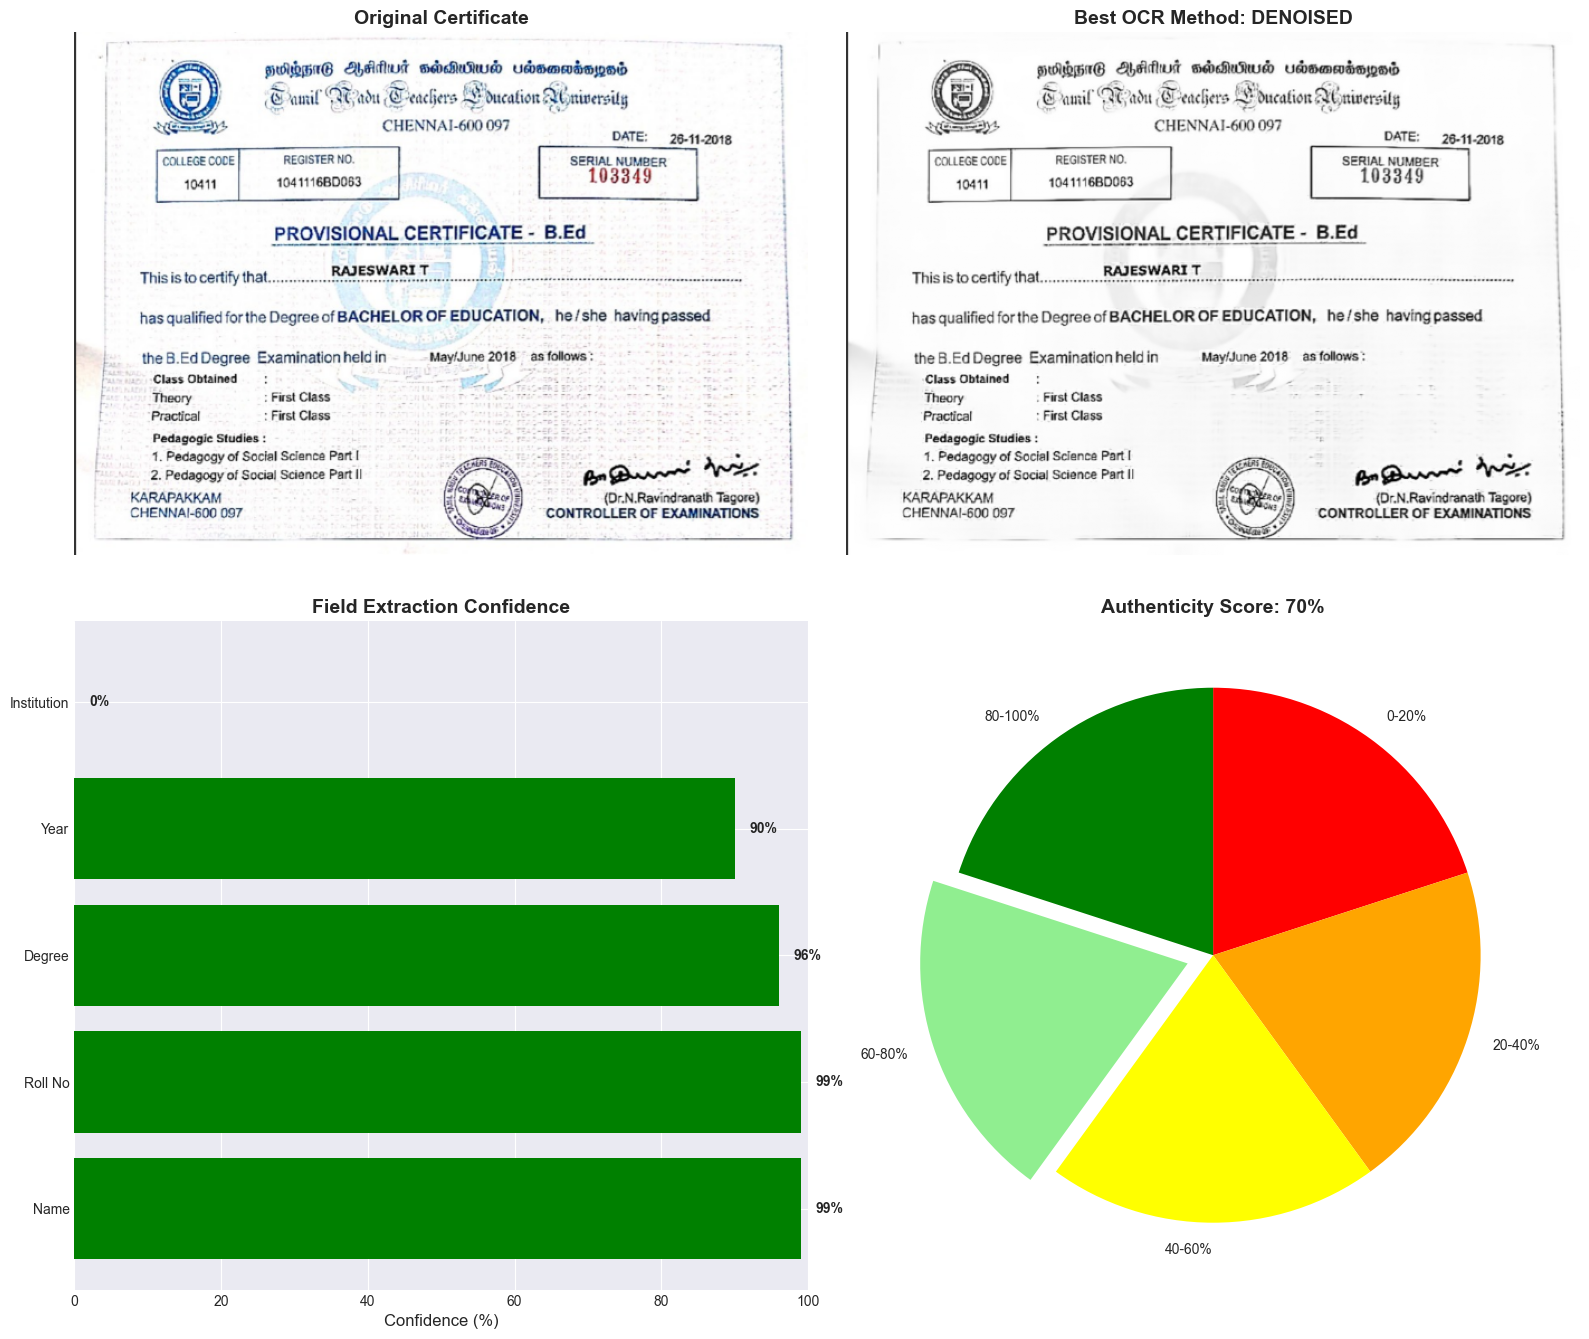

In [117]:
fig, axes = plt.subplots(2, 2, figsize=(16, 14))

# Original certificate
axes[0, 0].imshow(cert_rgb)
axes[0, 0].set_title("Original Certificate", fontsize=14, fontweight='bold')
axes[0, 0].axis('off')

# Best preprocessed version
best_preprocessed = preprocessed_images[best_method[0]]
axes[0, 1].imshow(best_preprocessed, cmap='gray')
axes[0, 1].set_title(f"Best OCR Method: {best_method[0].upper()}", fontsize=14, fontweight='bold')
axes[0, 1].axis('off')

# Confidence chart
fields = ['Name', 'Roll No', 'Degree', 'Year', 'Institution']
confidences = [name_confidence, roll_confidence, degree_confidence, year_confidence, inst_confidence]
colors = ['green' if c >= 80 else 'orange' if c >= 60 else 'red' for c in confidences]

axes[1, 0].barh(fields, confidences, color=colors)
axes[1, 0].set_xlabel('Confidence (%)', fontsize=12)
axes[1, 0].set_title('Field Extraction Confidence', fontsize=14, fontweight='bold')
axes[1, 0].set_xlim(0, 100)
for i, v in enumerate(confidences):
    axes[1, 0].text(v + 2, i, f'{v}%', va='center', fontweight='bold')

# Authenticity gauge
authenticity = 100 - tampering_score
colors_auth = ['red', 'orange', 'yellow', 'lightgreen', 'green']
sizes = [20, 20, 20, 20, 20]
explode = [0.1 if i == int(authenticity / 20) else 0 for i in range(5)]

axes[1, 1].pie(sizes, labels=['0-20%', '20-40%', '40-60%', '60-80%', '80-100%'],
               colors=colors_auth, explode=explode, autopct='',
               startangle=90, counterclock=False)
axes[1, 1].set_title(f'Authenticity Score: {authenticity}%', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()


In [ ]:
def verify_single_certificate(image_path):
    """
    Complete verification pipeline for a single certificate
    Returns a dictionary with all extracted information
    """
    try:
        # Load image
        img = cv2.imread(image_path)
        if img is None:
            return {'error': 'Could not load image'}
        
        # Preprocess
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        denoised = cv2.fastNlMeansDenoising(gray, None, 10, 7, 21)
        
        # OCR
        config = '--oem 3 --psm 6'
        text = pytesseract.image_to_string(denoised, lang='eng', config=config)
        lines = [l.strip() for l in text.split('\n') if l.strip()]
        
        # Extract fields
        name, name_conf = extract_name(lines, text)
        roll, roll_conf = extract_roll_number(lines, text)
        degree, deg_conf = extract_degree(lines, text)
        year, year_conf = extract_year(text)
        inst, inst_conf = extract_institution(lines, text)
        
        # Tampering detection
        tamp_score, verdict, _ = calculate_ela(image_path)
        
        # Calculate overall confidence
        confs = [c for c in [name_conf, roll_conf, deg_conf, year_conf, inst_conf] if c > 0]
        overall_conf = int(np.mean(confs)) if confs else 0
        
        return {
            'name': name,
            'roll_number': roll,
            'degree': degree,
            'year': year,
            'institution': inst,
            'confidences': {
                'name': name_conf,
                'roll': roll_conf,
                'degree': deg_conf,
                'year': year_conf,
                'institution': inst_conf,
                'overall': overall_conf
            },
            'tampering_score': tamp_score,
            'authenticity': 100 - tamp_score,
            'verdict': verdict
        }
        
    except Exception as e:
        return {'error': str(e)}

def batch_verify_certificates(image_folder):
    """
    Verify all certificates in a folder
    """
    from pathlib import Path
    
    folder = Path(image_folder)
    results = []
    
    # Find all images
    image_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff']
    image_files = [f for f in folder.iterdir() 
                   if f.suffix.lower() in image_extensions]
    
    print(f"Found {len(image_files)} certificates to verify\n")
    
    for i, img_file in enumerate(image_files, 1):
        print(f"[{i}/{len(image_files)}] Processing: {img_file.name}")
        result = verify_single_certificate(str(img_file))
        result['filename'] = img_file.name
        results.append(result)
    
    return results

print("\nTo verify multiple certificates:")
print("  results = batch_verify_certificates('./your_folder')")

✓ Batch processing functions ready!

To verify multiple certificates:
  results = batch_verify_certificates('./your_folder')


In [ ]:
def export_to_json(result_dict, output_file='verification_result.json'):
    """Export verification result to JSON"""
    result_dict['timestamp'] = datetime.now().isoformat()
    result_dict['image_path'] = image_path
    
    with open(output_file, 'w') as f:
        json.dump(result_dict, f, indent=2)
    
    print(f"Results saved to: {output_file}")

def export_to_csv(results_list, output_file='verification_results.csv'):
    """Export batch results to CSV"""
    import csv
    
    if not results_list:
        print("No results to export")
        return
    
    # Define CSV columns
    columns = ['filename', 'name', 'roll_number', 'degree', 'year', 
               'institution', 'overall_confidence', 'tampering_score', 
               'authenticity', 'verdict']
    
    with open(output_file, 'w', newline='', encoding='utf-8') as f:
        writer = csv.DictWriter(f, fieldnames=columns)
        writer.writeheader()
        
        for result in results_list:
            row = {
                'filename': result.get('filename', ''),
                'name': result.get('name', ''),
                'roll_number': result.get('roll_number', ''),
                'degree': result.get('degree', ''),
                'year': result.get('year', ''),
                'institution': result.get('institution', ''),
                'overall_confidence': result.get('confidences', {}).get('overall', 0),
                'tampering_score': result.get('tampering_score', 0),
                'authenticity': result.get('authenticity', 0),
                'verdict': result.get('verdict', '')
            }
            writer.writerow(row)
    
    print(f"Results saved to: {output_file}")

# Create result dictionary for current certificate
current_result = {
    'name': name,
    'roll_number': roll_no,
    'degree': degree,
    'year': year,
    'institution': institution,
    'confidences': {
        'name': name_confidence,
        'roll': roll_confidence,
        'degree': degree_confidence,
        'year': year_confidence,
        'institution': inst_confidence,
        'overall': overall_confidence
    },
    'tampering_score': tampering_score,
    'authenticity': 100 - tampering_score,
    'verdict': verdict
}

# Export current result
export_to_json(current_result)


Results saved to: verification_result.json

Results exported successfully!


In [126]:
try:
    import torch
    import torch.nn as nn
    from torchvision import transforms
    import timm
    
    HAS_TORCH = True
except ImportError:
    HAS_TORCH = False
    print("  PyTorch not available - skipping deep learning detection")

if HAS_TORCH:
    def load_tampering_model(model_path='./models/tamper_model.pth'):
        """Load pre-trained tampering detection model"""
        try:
            device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
            
            # Create model architecture
            model = timm.create_model('resnet18', pretrained=False, num_classes=2)
            
            # Load weights
            model.load_state_dict(torch.load(model_path, map_location=device))
            model = model.to(device)
            model.eval()
            
            print(f" Model loaded on {device}")
            return model, device
            
        except Exception as e:
            print(f" Could not load model: {e}")
            return None, None
    
    def predict_tampering_dl(image_path, model, device):
        """
        Predict tampering using deep learning
        Returns: (is_tampered, confidence)
        """
        try:
            # Prepare image
            transform = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
            
            img = Image.open(image_path).convert('RGB')
            img_tensor = transform(img).unsqueeze(0).to(device)
            
            # Predict
            with torch.no_grad():
                outputs = model(img_tensor)
                probabilities = torch.nn.functional.softmax(outputs, dim=1)
                pred_class = torch.argmax(probabilities, dim=1).item()
                confidence = probabilities[0][pred_class].item() * 100
            
            is_tampered = pred_class == 1
            
            return is_tampered, confidence
            
        except Exception as e:
            print(f"Prediction error: {e}")
            return None, 0
    
    dl_model, device = load_tampering_model()
    
    if dl_model is not None:
        print("Running deep learning tampering detection...")
        is_tampered, dl_confidence = predict_tampering_dl(image_path, dl_model, device)
        
        print(f"\n Deep Learning Analysis:")
        print(f"   Prediction: {'TAMPERED' if is_tampered else 'AUTHENTIC'}")
        print(f"   Confidence: {dl_confidence:.2f}%")
        
        # Compare with traditional ELA
        print(f"\n Comparison:")
        print(f"   Traditional ELA: {verdict.upper()} (score: {tampering_score})")
        print(f"   Deep Learning: {'TAMPERED' if is_tampered else 'AUTHENTIC'} ({dl_confidence:.1f}%)")
    else:
        print("   1. Train the model using train_tamper_model.py")
        print("   2. Place tamper_model.pth in ./models/ directory")

 Model loaded on cuda
Running deep learning tampering detection...

 Deep Learning Analysis:
   Prediction: AUTHENTIC
   Confidence: 99.80%

 Comparison:
   Traditional ELA: UNKNOWN (score: 30)
   Deep Learning: AUTHENTIC (99.8%)


In [127]:
### Datasets Used:
"""1. **Professional Certification Programs** (Authentic)
   - Source: Kaggle dataset of real certificates
   - Category: Authentic/Real

2. **CASIA 1050** (Mixed)
   - Contains authentic and tampered images
   - Need to separate into two folders

3. **DEFACTO Copy-Move** (Tampered)
   - Copy-move forgery detection dataset
   - Category: Tampered

4. **Text Detection in Documents** (Authentic)
   - Clean document images
   - Category: Authentic

5. **TextOCR Dataset** (Authentic)
   - Text extraction images
   - Category: Authentic

6. **Standard OCR Dataset** (Authentic)
   - Clean OCR images
   - Category: Authentic ###"""


def show_dataset_info():
    """Display information about the datasets used"""
    datasets = {
        "Professional Certification Programs": {
            "url": "https://www.kaggle.com/datasets/thedevastator/professional-certification-programs",
            "type": "Authentic",
            "description": "Real professional certificates"
        },
        "CASIA CGDB1050": {
            "url": "https://www.kaggle.com/datasets/saurabhshahane/cg1050",
            "type": "Mixed (Authentic + Tampered)",
            "description": "Image forgery detection dataset"
        },
        "DEFACTO Copy-Move": {
            "url": "https://www.kaggle.com/datasets/defactodataset/defactocopymove/data",
            "type": "Tampered",
            "description": "Copy-move forgery examples"
        },
        "Text Detection in Documents": {
            "url": "https://www.kaggle.com/datasets/trainingdatapro/text-detection-in-the-documents",
            "type": "Authentic",
            "description": "Clean document images"
        },
        "TextOCR": {
            "url": "https://www.kaggle.com/datasets/robikscube/textocr-text-extraction-from-images-dataset",
            "type": "Authentic",
            "description": "Text extraction dataset"
        },
        "Standard OCR Dataset": {
            "url": "https://www.kaggle.com/datasets/preatcher/standard-ocr-dataset",
            "type": "Authentic",
            "description": "Standard OCR images"
        }
    }
    
    print("📚 Datasets Used for Training\n")
    print("=" * 80)
    
    for name, info in datasets.items():
        print(f"\n{name}")
        print(f"  Type: {info['type']}")
        print(f"  Description: {info['description']}")
        print(f"  URL: {info['url']}")
    
    print("\n" + "=" * 80)


print("\n To train your own model:")
print("   python train_tamper_model.py --data_dir ./organized_dataset --epochs 30")


 To train your own model:
   python train_tamper_model.py --data_dir ./organized_dataset --epochs 30


In [128]:
def analyze_performance(results_dict):
    """Analyze verification performance"""
    
    print("Performance Analysis")
    print("=" * 80)
    
    # Field extraction success rate
    fields_extracted = sum([
        1 if results_dict.get('name') else 0,
        1 if results_dict.get('roll_number') else 0,
        1 if results_dict.get('degree') else 0,
        1 if results_dict.get('year') else 0,
        1 if results_dict.get('institution') else 0
    ])
    
    extraction_rate = (fields_extracted / 5) * 100
    
    print(f"\n✓ Field Extraction Rate: {extraction_rate:.0f}%")
    print(f"  Successfully extracted {fields_extracted}/5 fields")
    
    # Confidence analysis
    confidences = results_dict.get('confidences', {})
    avg_conf = confidences.get('overall', 0)
    
    print(f"\n✓ Average Confidence: {avg_conf}%")
    if avg_conf >= 80:
        print("  Excellent - High confidence in extracted data")
    elif avg_conf >= 60:
        print("  Good - Reasonable confidence")
    else:
        print("  Low - Manual verification recommended")
    
    # Tampering detection
    tamp_score = results_dict.get('tampering_score', 0)
    print(f"\n✓ Tampering Detection: {tamp_score}/100")
    if tamp_score < 20:
        print("  Low risk - Certificate appears authentic")
    elif tamp_score < 60:
        print("  Medium risk - Some concerns detected")
    else:
        print("  High risk - Significant tampering indicators")
    
    # Overall assessment
    print("\n" + "-" * 80)
    print("Overall Assessment:")
    
    if extraction_rate >= 80 and avg_conf >= 70 and tamp_score < 30:
        print("  VERIFICATION SUCCESSFUL")
        print("  Certificate appears genuine with high confidence")
    elif extraction_rate >= 60 and avg_conf >= 50 and tamp_score < 60:
        print("  VERIFICATION UNCERTAIN")
        print("  Manual verification recommended")
    else:
        print("  VERIFICATION FAILED")
        print("  Significant issues detected - likely forged")
    
    print("=" * 80)

# Analyze current certificate
analyze_performance(current_result)

Performance Analysis

✓ Field Extraction Rate: 80%
  Successfully extracted 4/5 fields

✓ Average Confidence: 96%
  Excellent - High confidence in extracted data

✓ Tampering Detection: 30/100
  Medium risk - Some concerns detected

--------------------------------------------------------------------------------
Overall Assessment:
  VERIFICATION UNCERTAIN
  Manual verification recommended


In [ ]:
import pickle
from datetime import datetime

session_data = {
    'timestamp': datetime.now().isoformat(),
    'image_path': image_path,
    'extracted_data': current_result,
    'ocr_confidence': overall_confidence,
    'tampering_analysis': {
        'score': tampering_score,
        'verdict': verdict,
        'authenticity': 100 - tampering_score
    },
    'preprocessing_methods': list(preprocessed_images.keys()),
    'best_ocr_method': best_method[0]
}

# Save as pickle
with open('session_data.pkl', 'wb') as f:
    pickle.dump(session_data, f)

# Save as JSON (more readable)
with open('session_data.json', 'w') as f:
    json.dump(session_data, f, indent=2, default=str)

print(" Session data saved!")
print("  - session_data.pkl (binary format)")
print("  - session_data.json (human-readable)")
print("  - verification_result.json (detailed results)")

print("\n To load session data later:")
print("  with open('session_data.pkl', 'rb') as f:")
print("      data = pickle.load(f)")

✓ Session data saved!
  - session_data.pkl (binary format)
  - session_data.json (human-readable)
  - verification_result.json (detailed results)

 To load session data later:
  with open('session_data.pkl', 'rb') as f:
      data = pickle.load(f)
